# Assignment "Assignment" System for DCT Academy's Code Platform

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import scipy.sparse as sparse
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import random
import implicit
import requests
import json

## Creating list of dataframe of all tables, a dictionary mapping to corresponding dataframe

In [2]:
# Dictionary of all the tables and their columns
table_columns = {}

# Dictionary of all dataframes mapped with table names
df_all = {}

# List of all dataframes of all tables
df_list = []

request_tables = ['submissions', 'assignments', 'tags', 'taggings']

for table in request_tables:
    url = 'http://code.dctacademy.com/api/v1/ml/data/' + table + '?key=6eccc23db96ed84fce329e0d20bdacb4'
    response = requests.get(url)
#     print(response.status_code, response.reason)
    df_all[table] = pd.read_json(response.content)
    
model_path = '../ml-api/model/'

## Get all student/user assignments
### Merge submissions, assignments, taggings, tags

In [3]:
user_submissions = df_all['submissions'] \
    .merge(df_all['assignments'], left_on='assignment_id', right_on='id', suffixes=('_submissions', '_assignments')) \
    .merge(df_all['taggings'], left_on='id_assignments', right_on='taggable_id', suffixes=('_sub_ass', '_taggings')) \
    .merge(df_all['tags'], left_on='tag_id', right_on='id', suffixes=('_sub_ass_tag', '_tags')) 

submission_assignments = df_all['submissions'] \
    .merge(df_all['assignments'], left_on='assignment_id', right_on='id', suffixes=('_submissions', '_assignments'))

user_submissions.drop(['statement', 'output', 'language', 'created_at_submissions', 'updated_at_submissions', 'is_checked', 'body', 'url', 
                       'created_at_assignments', 'updated_at_assignments', 'pass', 'fail', 'tagger_type', 'created_at', 'total', 'practice_id', 
                       'assignment_id', 'user_id_assignments', 'code_assignments', 'tagger_id', 'tag_id', 'source', 'input_size',
                       'approved', 'function_name', 'context', 'id_sub_ass_tag', 'taggings_count', 'is_allowed'], axis=1, inplace=True)

In [4]:
user_submissions.columns

Index(['code_submissions', 'id_submissions', 'points_submissions',
       'time_in_seconds', 'user_id_submissions', 'video_url', 'display_helper',
       'id_assignments', 'is_front_end', 'minutes', 'points_assignments',
       'title', 'taggable_id', 'taggable_type', 'id_tags', 'name'],
      dtype='object')

In [5]:
user_submissions = user_submissions[user_submissions['taggable_type'] == 'Assignment']

In [6]:
user_submissions.head()

,code_submissions,id_submissions,points_submissions,time_in_seconds,user_id_submissions,video_url,display_helper,id_assignments,is_front_end,minutes,points_assignments,title,taggable_id,taggable_type,id_tags,name
0,"{'statement': '#type ruby code here str1 = ""Vi...",5,0.0,0,11,None,"{""function_name"":""mergeStrings"",""input_size"":""...",13,False,10,10,Merge two strings,13,Assignment,2,easy
1,"{'statement': 'str1 =""virat"" str2 = ""kohli"" ...",4,0.0,0,13,None,"{""function_name"":""mergeStrings"",""input_size"":""...",13,False,10,10,Merge two strings,13,Assignment,2,easy
2,"{'statement': 'def merge_strings(str1, str2) ...",13,0.0,0,18,None,"{""function_name"":""mergeStrings"",""input_size"":""...",13,False,10,10,Merge two strings,13,Assignment,2,easy
3,"{'statement': 'class Test def merge(data1, da...",14,0.0,0,17,None,"{""function_name"":""mergeStrings"",""input_size"":""...",13,False,10,10,Merge two strings,13,Assignment,2,easy
4,{'statement': '#type ruby code here def merge(...,12,0.0,0,19,None,"{""function_name"":""mergeStrings"",""input_size"":""...",13,False,10,10,Merge two strings,13,Assignment,2,easy


In [7]:
user_submissions.describe()

,id_submissions,points_submissions,time_in_seconds,user_id_submissions,id_assignments,minutes,points_assignments,taggable_id,id_tags
count,13054.000000,13054.000000,1.305400e+04,13054.000000,13054.000000,13054.000000,13054.000000,13054.000000,13054.000000
mean,2789.681707,10.750636,1.399303e+05,66.040294,224.052704,16.990195,14.734181,224.052704,11.611000
std,1747.536206,8.282556,7.179423e+05,28.245738,154.678437,10.230039,7.307517,154.678437,6.147618
min,1.000000,0.000000,-4.049430e+05,3.000000,13.000000,5.000000,10.000000,13.000000,2.000000
25%,1287.000000,5.000000,4.200000e+02,44.000000,67.000000,10.000000,10.000000,67.000000,7.000000
50%,2580.000000,10.000000,1.445000e+03,64.000000,174.000000,15.000000,10.000000,174.000000,13.000000
75%,4374.750000,10.000000,1.159500e+04,85.000000,364.000000,20.000000,20.000000,364.000000,16.000000
max,5913.000000,50.000000,1.441983e+07,129.000000,471.000000,60.000000,50.000000,471.000000,30.000000


### Cleaning tags and categories

In [8]:
user_submissions['name'] = user_submissions['name'].str.strip().replace('/',',')

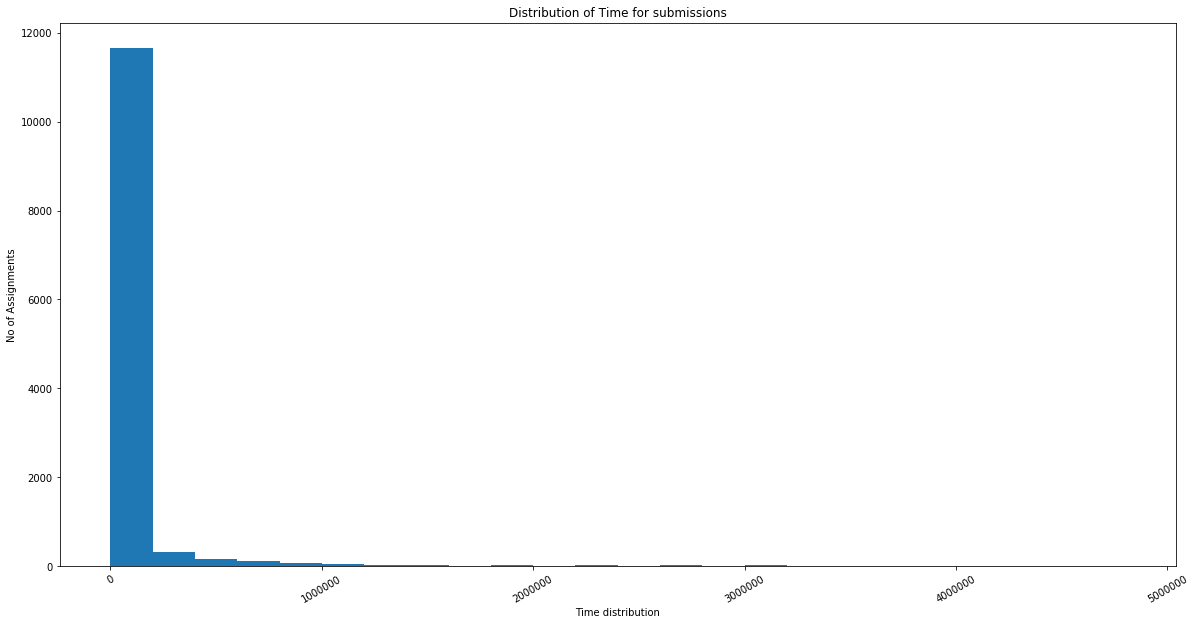

In [9]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='30')
plt.hist(user_submissions['time_in_seconds'], bins=np.arange(0, 5000000, 200000))
plt.title('Distribution of Time for submissions')
plt.xlabel('Time distribution')
plt.ylabel('No of Assignments')
plt.show()

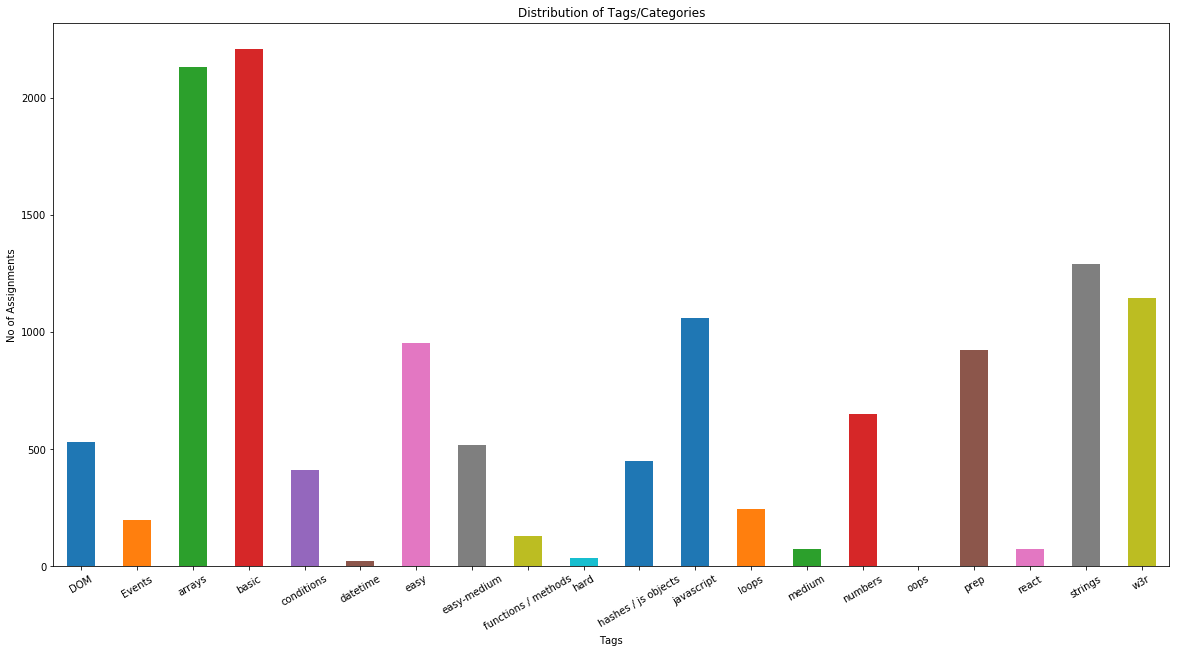

In [10]:
plt.figure(figsize=(20, 10))
user_submissions.groupby(['name']).count()['time_in_seconds'].plot(kind='bar')
plt.xticks(rotation='30')
plt.title('Distribution of Tags/Categories')
plt.xlabel('Tags')
plt.ylabel('No of Assignments')
plt.show()

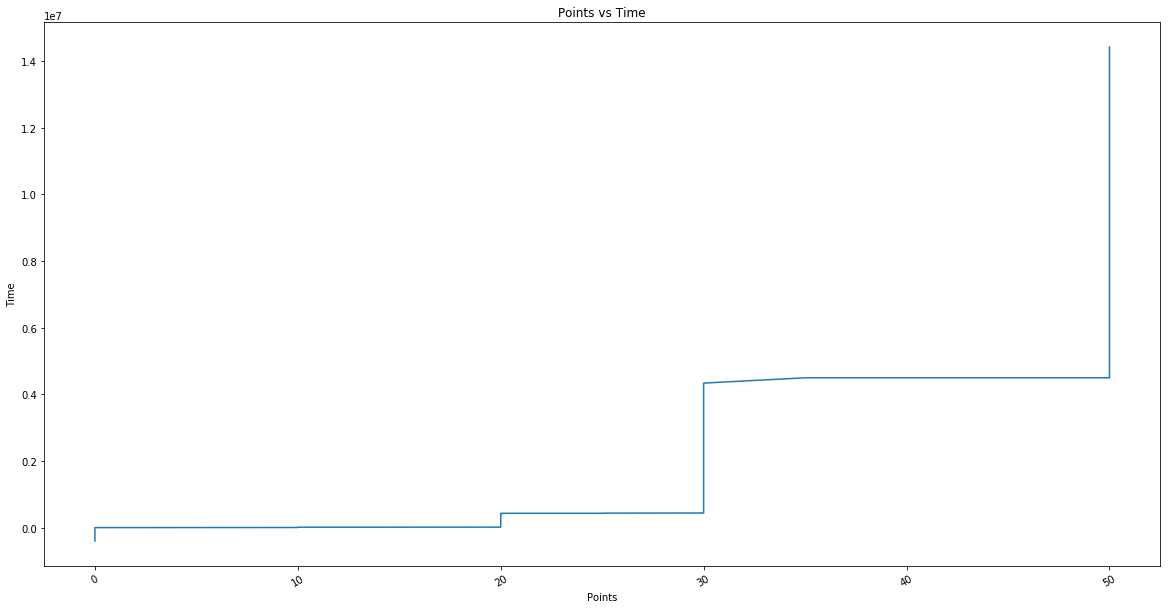

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(user_submissions['points_submissions'].sort_values(), user_submissions['time_in_seconds'].sort_values())
plt.xticks(rotation='30')
plt.title('Points vs Time')
plt.xlabel('Points')
plt.ylabel('Time')
plt.show()

In [12]:
user_submissions['time_in_seconds'] = user_submissions['time_in_seconds'].abs()
user_submissions['time_in_seconds'].describe().apply(lambda x: format(x, 'f'))

count       13054.000000
mean       141768.130535
std        717581.594191
min             0.000000
25%           474.000000
50%          1615.500000
75%         15530.750000
max      14419832.000000
Name: time_in_seconds, dtype: object

### Removing all submissions with time greater than 100,000 seconds

In [13]:
median = user_submissions['time_in_seconds'].median() 
user_submissions.loc[user_submissions.time_in_seconds > 100000, 'time_in_seconds'] = np.nan
user_submissions.fillna(median, inplace=True)
user_submissions['time_in_seconds'].describe().apply(lambda x: format(x, 'f'))

count    13054.000000
mean      8367.372491
std      19047.465713
min          0.000000
25%        474.000000
50%       1615.250000
75%       3556.750000
max      99489.000000
Name: time_in_seconds, dtype: object

### Getting submissions which are greater than 0 and lesser than 100000

In [14]:
user_submissions = user_submissions[(user_submissions['time_in_seconds'] > 100) & (user_submissions['time_in_seconds'] < 100000)]

### Top 20 fastest submissions

In [15]:
user_submissions[['title', 'time_in_seconds']].sort_values('time_in_seconds').head(20)

,title,time_in_seconds
13122,Random Element,101.0
16377,Find Even or Odd,101.0
6330,Random Element,101.0
12376,Ones and Zeros,101.0
424,Ones and Zeros,101.0
23860,Find Even or Odd,101.0
16074,Ones and Zeros,101.0
4215,Random Element,101.0
15705,Ones and Zeros,101.0
10486,find max number without using built in function,103.0


### Top 20 slowest submissions

In [16]:
user_submissions[['title', 'time_in_seconds']].sort_values('time_in_seconds').tail(20)

,title,time_in_seconds
2401,find all permutations of String,95549.0
10934,find all permutations of String,95549.0
13383,Find Product based on id,95959.0
774,Find Product based on id,95959.0
21670,Find Product based on id,95959.0
5821,Parameterize,96060.0
1536,Parameterize,96060.0
3442,Parameterize,96060.0
4753,String Count,96663.0
2132,String Count,96663.0


In [17]:
user_submissions.reset_index(inplace=True)

### Creating the confidence column

In [18]:
user_submissions['name'] = user_submissions['name'].apply(lambda x:x.lower())
tags = df_all['tags']['name'].apply(lambda x:x.lower()).unique()
tags.sort()
tag_points = [10, 5, 15, 20, 15, 10, 25, 25, 25, 25, 50, 20, 20, 100, 15, 20, 5, 5, 5, 75, 20, 15, 15, 5, 5, 10, 15, 5, 5, 5, 5, 75, 20, 15, 15, 5, 5, 10, 15, 5]

In [19]:
mapping = dict(zip(tags, tag_points))

assignment_tags = user_submissions.groupby(['id_assignments']).aggregate(lambda x: list(set(x)))['name'].to_frame()
assignment_points = assignment_tags['name'].apply(lambda x:[mapping[i] for i in x]).apply(lambda x:sum(x)).to_frame()

In [20]:
len(tags)

40

In [21]:
user_submissions['assignment_points'] = user_submissions['id_assignments'].apply(lambda x: assignment_points.loc[x])
user_submissions['confidence'] = ((user_submissions['points_submissions'] / user_submissions['points_assignments']) + (user_submissions['minutes'] / (user_submissions['time_in_seconds'] / 60))) * user_submissions['assignment_points']
user_submissions['confidence'] = user_submissions['confidence'].abs()

### Preparing for sparse matrix

In [22]:
user_submissions = user_submissions.groupby(['user_id_submissions', 'id_assignments']).aggregate(lambda x:max(set(x)))['confidence'].reset_index()
user_submissions.head()

,user_id_submissions,id_assignments,confidence
0,3,23,258.620690
1,3,26,200.374449
2,3,30,385.084746
3,3,33,222.222222
4,3,34,86.353945


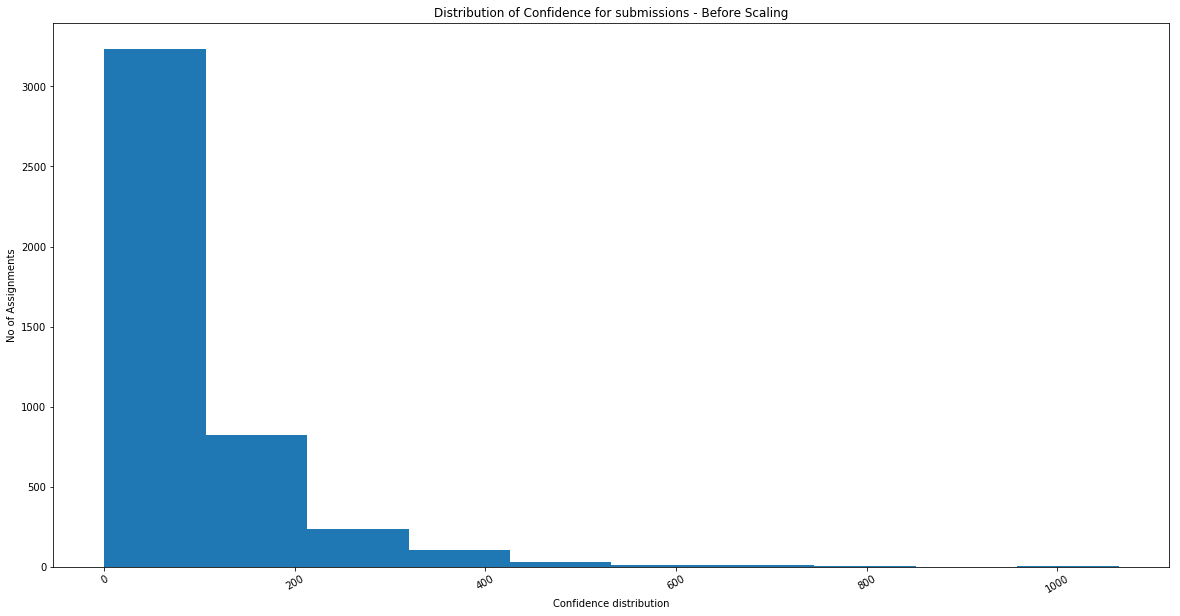

In [23]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='30')
plt.hist(user_submissions['confidence'])
plt.title('Distribution of Confidence for submissions - Before Scaling')
plt.xlabel('Confidence distribution')
plt.ylabel('No of Assignments')
plt.show()

### Creating sparse matrix 

In [24]:
user_submissions_pivot = user_submissions.pivot_table(values='confidence', index='id_assignments', columns='user_id_submissions', fill_value=0)
user_submissions.to_csv(model_path + 'user_submissions.csv', index=False)
user_submissions_pivot.to_csv(model_path + 'user_submissions_pivot.csv')
user_submissions_pivot.head()

user_id_submissions,3,13,14,17,18,19,20,21,22,23,...,116,117,118,119,120,122,123,126,128,129
id_assignments,,,,,,,,,,,,,,,,,,,,,
13,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,81.570997,33.834586,0.0,0.0,0.0,0.0,13.138686,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
matrix_size = user_submissions_pivot.shape[0] * user_submissions_pivot.shape[1] 
interactions = user_submissions_pivot.astype(bool).sum(axis=0).sum()
sparsity = 100 * (1 - (interactions / matrix_size))
sparsity

76.68029778756423

### Creating a Training and Validation Set

#### Hide a certain percentage of the user/item interactions from the model_als during the training phase chosen at random.

This function will take in the original user-assignment matrix and "mask" a percentage of the original id_assignments where a user-assignment interaction has taken place for use as a test set. The test set will contain all of the original assignments, while the training set replaces the specified percentage of them with a zero in the original assignments matrix. 
    
* **parameters**: 
    
    1. **id_assignments** - the original id_assignments matrix from which you want to generate a train/test set. Test is just a complete copy of the original set. This is in the form of a sparse csr_matrix. 
    
    2. **pct_test** - The percentage of user-assignment interactions where an interaction took place that you want to mask in the training set for later comparison to the test set, which contains all of the original id_assignments. 
    
* **returns**:
    
    1. **training_set** - The altered version of the original data with a certain percentage of the user-assignment pairs that originally had interaction set back to zero.
    
    2. **test_set** - A copy of the original id_assignments matrix, unaltered, so it can be used to see how the rank order compares with the actual interactions.
    
    3. **user_inds** - From the randomly selected user-assignment indices, which user rows were altered in the training data. This will be necessary later when evaluating the performance via AUC.

In [26]:
def make_train(id_assignments, pct_test = 0.2):
    # Make a copy of the original set to be the test set. 
    test_set = id_assignments.copy() 
    
    # Store the test set as a binary preference matrix
    test_set[test_set != 0] = 1 
    
    # Make a copy of the original data we can alter as our training set. 
    training_set = id_assignments.copy() 
    
    # Find the indices in the assignments data where an interaction exists
    nonzero_inds = training_set.nonzero() 
    
    # Zip these pairs together of user,item index into list
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) 
    
    # Set the random seed to zero for reproducibility
    random.seed(0) 
    
    # Round the number of samples needed to the nearest integer
    num_samples = int(np.ceil(pct_test * len(nonzero_pairs))) 
    
    # Sample a random number of user-item pairs without replacement
    samples = random.sample(nonzero_pairs, num_samples) 
    
    # Get the user row indices
    user_inds = [index[0] for index in samples] 
    
    # Get the item column indices
    assignment_inds = [index[1] for index in samples] 
    
    # Assign all of the randomly chosen user-item pairs to zero
    training_set[user_inds, assignment_inds] = 0 
    
    # Get rid of zeros in sparse array storage after update to save space
    training_set.eliminate_zeros() 
    
    # Output the unique list of user rows that were altered  
    return training_set, test_set, list(set(user_inds)) 

In [27]:
assignment_train, assignment_test, assignment_users_altered = make_train(sparse.csr_matrix(user_submissions_pivot.values), pct_test = 0.2)

### Saving the model_als

In [28]:
model_als = implicit.als.AlternatingLeastSquares(factors=32, regularization = 0.29, iterations = 5)
model_als.fit(assignment_train)

user_vecs_als = model_als.item_factors
item_vecs_als = model_als.user_factors

filename = 'user_assignments_model_als.pkl'
joblib.dump(model_als, model_path + filename)

100%|█████████████████████████████████████████████████████████████████████████████████| 5.0/5 [00:00<00:00, 104.17it/s]


['../ml-api/model/user_assignments_model_als.pkl']

### Saving the model_bayes

In [29]:
model_bayes = implicit.bpr.BayesianPersonalizedRanking(factors=95, learning_rate=0.2, regularization = 0.1, iterations = 50)
model_bayes.fit(assignment_train)

user_vecs_bayes = model_bayes.item_factors
item_vecs_bayes = model_bayes.user_factors

filename = 'user_assignments_model_bayes.pkl'
joblib.dump(model_bayes, model_path + filename)

100%|█████████████████████████████████████████████████| 50/50 [00:00<00:00, 359.71it/s, correct=91.36%, skipped=40.16%]


['../ml-api/model/user_assignments_model_bayes.pkl']

### Testing out the model_als for one user and one assignment

In [30]:
user_id = 37
assignment_id = 344
user_assignments = list(user_submissions[user_submissions['user_id_submissions'] == user_id]['id_assignments'])

user_id_index = list(user_submissions_pivot.columns).index(user_id)
assignment_id_index = list(user_submissions_pivot.index).index(assignment_id)

In [31]:
user_recommendations_als = model_als.recommend(user_id_index, sparse.csr_matrix(user_submissions_pivot.values), N=20)

In [32]:
user_recommendations_bayes = model_bayes.recommend(user_id_index, sparse.csr_matrix(user_submissions_pivot.values), N=20)

In [33]:
related_assignments_als = model_als.similar_items(assignment_id_index, N=20)

In [34]:
related_assignments_bayes = model_bayes.similar_items(assignment_id_index, N=20)

In [35]:
list_of_recommended_submissions_als = [i[0] for i in user_recommendations_als]
list_of_recommended_submissions_als = user_submissions['id_assignments'][list_of_recommended_submissions_als]
list_of_recommended_submissions_als

12     102
35      37
95      83
112     50
92      77
88      65
118     75
109     41
33      34
16     141
13     106
100    321
75      23
14     124
62      27
159    320
108     37
121     80
18     149
106     33
Name: id_assignments, dtype: int64

In [36]:
list_of_recommended_submissions_bayes = [i[0] for i in user_recommendations_bayes]
list_of_recommended_submissions_bayes = user_submissions['id_assignments'][list_of_recommended_submissions_bayes]
list_of_recommended_submissions_bayes

62      27
13     106
102    323
61      50
33      34
142     51
4       34
92      77
35      37
60      47
8       69
113     51
90      74
75      23
74     406
109     41
140     49
112     50
147     73
12     102
Name: id_assignments, dtype: int64

In [37]:
list_of_related_submissions_als = [i[0] for i in related_assignments_als]
list_of_related_submissions_als = user_submissions['id_assignments'][list_of_related_submissions_als]
list_of_related_submissions_als

101    322
92      77
112     50
121     80
3       33
63      37
42      62
102    323
159    320
166     26
4       34
74     406
20     342
53     324
59      34
47      77
117     74
153     83
122     83
135     33
Name: id_assignments, dtype: int64

In [38]:
list_of_related_submissions_bayes = [i[0] for i in related_assignments_bayes]
list_of_related_submissions_bayes = user_submissions['id_assignments'][list_of_related_submissions_bayes]
list_of_related_submissions_bayes

101    322
121     80
113     51
166     26
3       33
159    320
148     74
147     73
182     74
20     342
112     50
140     49
156    106
52     323
132     23
22     349
120     78
152     80
92      77
78      33
Name: id_assignments, dtype: int64

In [39]:
submission_assignments.columns

Index(['assignment_id', 'code_submissions', 'created_at_submissions', 'fail',
       'id_submissions', 'is_checked', 'language', 'output', 'pass',
       'points_submissions', 'practice_id', 'statement', 'time_in_seconds',
       'total', 'updated_at_submissions', 'user_id_submissions', 'video_url',
       'approved', 'body', 'code_assignments', 'created_at_assignments',
       'display_helper', 'function_name', 'id_assignments', 'input_size',
       'is_allowed', 'is_front_end', 'minutes', 'points_assignments', 'source',
       'title', 'updated_at_assignments', 'url', 'user_id_assignments'],
      dtype='object')

In [40]:
submission_assignments[submission_assignments['id_assignments'].isin(list_of_recommended_submissions_als)]['title'].unique()

array(['Count Up then Down', 'Stock Portfolio', 'Authenticate!!!',
       'Generate an Array by Range', 'Password Generator', 'Clone Array',
       'Say Again', 'Function Runner', 'Dash between even',
       'First n elements in array', 'Join Array Elements', 'Print Array',
       'Find a word', 'Pet Name Generator', 'User Count',
       'Party on Pay Day', 'Remove  Specific Element',
       ' Capitalize each Word ', 'Fullstack Jack'], dtype=object)

In [41]:
submission_assignments[submission_assignments['id_assignments'].isin(list_of_recommended_submissions_bayes)]['title'].unique()

array(['Count Up then Down', 'Stock Portfolio', 'Proper Noun Filter',
       'Array or not', 'Say Again', 'Remove Zeros', 'isPrime',
       'Function Runner', 'Parameterize', 'First n elements in array',
       'Print Array', 'Find a word', 'Pet Name Generator', 'Date Ranges',
       'slice without built in function', 'convert to array',
       'Fullstack Jack'], dtype=object)

In [42]:
submission_assignments[submission_assignments['id_assignments'].isin(list_of_related_submissions_als)]['title'].unique()

array(['The Array Cafe', 'Count Up then Down', 'Stock Portfolio',
       'Authenticate!!!', 'Frequency Counter', 'Parameterize',
       'Dash between even', 'First n elements in array',
       'Join Array Elements', 'Pet Name Generator', 'Date Ranges',
       'slice without built in function', 'User Count', 'Valid Date',
       'Casual Leaves', 'Get the mean of an array'], dtype=object)

In [43]:
submission_assignments[submission_assignments['id_assignments'].isin(list_of_related_submissions_bayes)]['title'].unique()

array(['The Array Cafe', 'Stock Portfolio', 'Authenticate!!!',
       'Array or not', 'Say Again', 'Remove Zeros', 'isPrime',
       'Parameterize', 'First n elements in array', 'Last n Elements',
       'Join Array Elements', 'Print Array', 'Date Ranges', 'User Count',
       'Valid Date', 'Get the mean of an array', 'Sum positive Numbers'],
      dtype=object)

### Evaluating the Recommender System

This simple function will output the area under the curve using sklearn's metrics. 
    
* **parameters**:
    
   1. **predictions**: your prediction output
    
   2. **test**: the actual target result you are comparing to
* **returns**:
    
   1. AUC (area under the Receiver Operating Characterisic curve)

In [44]:
def auc_score(predictions, test):
    
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)   

This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
* **parameters**:
    
    1. **training_set** - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model_als 
    
    2. **predictions** - The matrix of your predicted assignments for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    3. **altered_users** - The indices of the users where at least one user/item pair was altered from make_train function
    
    4. **test_set** - The test set constucted earlier from make_train function
    
    
    
* **returns**:
    
   1. **The mean AUC** (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.

In [45]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    # An empty list to store the AUC for each user that had an item removed from the training set
    store_auc = [] 
    
    # To store popular AUC scores
    popularity_auc = [] 
    
    # Get sum of item iteractions to find most popular
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) 
    item_vecs_als = predictions[1]
    
    # Iterate through each user that had an item altered
    for user in altered_users[:50]: 
        
        # Get the training set row
        training_row = training_set[user, :].toarray().reshape(-1)
        
        # Find where the interaction had not yet occurred
        zero_inds = np.where(training_row == 0) 
        
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user, :]
        pred = user_vec.dot(item_vecs_als)[zero_inds[0]].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all assignments from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
        # End users iteration

    # Return the mean AUC rounded to three decimal places for both test and popularity benchmark    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  

In [46]:
calc_mean_auc(assignment_train, assignment_users_altered, [user_vecs_als, item_vecs_als.T], assignment_test)
# AUC for our recommender system

(0.948, 0.672)

In [47]:
calc_mean_auc(assignment_train, assignment_users_altered, [user_vecs_bayes, item_vecs_bayes.T], assignment_test)
# AUC for our recommender system

(0.871, 0.672)

In [48]:
# factors = np.arange(32, 1000, 32)
# regu = np.arange(0.01, 2, 0.01)
# iterations = np.arange(1, 10, 1)

# def tune_parameters(assignment_train, assignment_users_altered, user_vecs_als, item_vecs_als, assignment_test):
#     mean_auc = (0, 0)
    
#     for i in factors:
#         for j in regu:
#             for k in iterations:                
#                 mean_auc = calc_mean_auc(assignment_train, assignment_users_altered, [user_vecs_als, item_vecs_als.T], assignment_test)
#                 model_als = implicit.als.AlternatingLeastSquares(factors=i, regularization = j, iterations = k)
#                 model_als.fit(assignment_train)

#                 user_vecs_als = model_als.item_factors
#                 item_vecs_als = model_als.user_factors
                
#                 if mean_auc[0] > 0.96:
#                     print(mean_auc, i, j, k)
#                     return
                
                    
# tune_parameters(assignment_train, assignment_users_altered, user_vecs_als, item_vecs_als, assignment_test)      

In [49]:
# factors = np.arange(95, 1000, 31)
# regu = np.arange(0.1, 2, 0.1)
# iterations = np.arange(69, 100, 1)
# l_rate = np.arange(0.3, 2, 0.1)

# def tune_parameters(assignment_train, assignment_users_altered, user_vecs_bayes, item_vecs_bayes, assignment_test):
#     mean_auc = (0, 0)
    
#     for i in factors:
#         for j in regu:
#             for k in iterations:  
#                 for l in l_rate:
#                     try:
#                         mean_auc = calc_mean_auc(assignment_train, assignment_users_altered, [user_vecs_bayes, item_vecs_bayes.T], assignment_test)
#                     except Exception:
#                         pass
                    
#                     model_bayes = implicit.bpr.BayesianPersonalizedRanking(factors=i, learning_rate=l, regularization = j, iterations = k, use_gpu=True)
#                     model_bayes.fit(assignment_train)

#                     user_vecs_bayes = model_bayes.item_factors
#                     item_vecs_bayes = model_bayes.user_factors

#                     print(mean_auc, i, j, k, l)
                    
#                     if mean_auc[0] > 0.96:
#                         print(mean_auc, i, j, k, l)
#                         return
                
                    
# tune_parameters(assignment_train, assignment_users_altered, user_vecs_bayes, item_vecs_bayes, assignment_test)      